# Adadelta
Adadelta 算是 Adagrad 法的延伸，它跟 RMSProp 一样，都是为了解决 Adagrad 中学习率不断减小的问题，RMSProp 是通过移动加权平均的方式，而 Adadelta 也是一种方法，有趣的是，它并不需要学习率这个参数。

## Adadelta 法
Adadelta 跟 RMSProp 一样，先使用移动平均来计算 s

$$
s = \rho s + (1 - \rho) g^2
$$

这里 $\rho$ 和 RMSProp 中的 $\alpha$ 都是移动平均系数，g 是参数的梯度，然后我们会计算需要更新的参数的变化量

$$
g' = \frac{\sqrt{\Delta \theta + \epsilon}}{\sqrt{s + \epsilon}} g
$$

$\Delta \theta$ 初始为 0 张量，每一步做如下的指数加权移动平均更新

$$
\Delta \theta = \rho \Delta \theta + (1 - \rho) g'^2
$$

最后参数更新如下

$$
\theta = \theta - g'
$$

下面我们实现以下 Adadelta

In [1]:
def adadelta(parameters, sqrs, deltas, rho):
    eps = 1e-6
    for param, sqr, delta in zip(parameters, sqrs, deltas):
        sqr[:] = rho * sqr + (1 - rho) * param.grad.data ** 2
        cur_delta = torch.sqrt(delta + eps) / torch.sqrt(sqr + eps) * param.grad.data
        delta[:] = rho * delta + (1 - rho) * cur_delta ** 2
        param.data = param.data - cur_delta

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [3]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项和 delta 项
sqrs = []
deltas = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    deltas.append(torch.zeros_like(param.data))

# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        adadelta(net.parameters(), sqrs, deltas, 0.9) # rho 设置为 0.9
        # 记录误差
        train_loss += loss.data[0]
        if idx % 30 == 0:
            losses.append(loss.data[0])
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.371289
epoch: 1, Train Loss: 0.163695
epoch: 2, Train Loss: 0.125614
epoch: 3, Train Loss: 0.106515
epoch: 4, Train Loss: 0.094213
使用时间: 58.22260 s


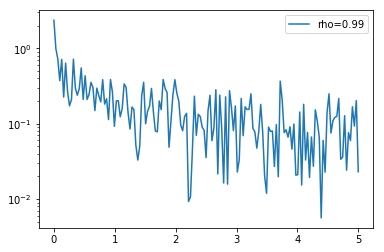

In [4]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='rho=0.99')
plt.legend(loc='best')

可以看到使用 adadelta 跑 5 次能够得到更小的 loss

**小练习：思考一下为什么 Adadelta 没有学习率这个参数，它是被什么代替了**

当然 pytorch 也内置了 adadelta 的方法，非常简单，只需要调用 `torch.optim.Adadelta()` 就可以了，下面是例子

In [6]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.Adadelta(net.parameters(), rho=0.9)

# 开始训练
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data[0]
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.363492
epoch: 1, Train Loss: 0.159191
epoch: 2, Train Loss: 0.122447
epoch: 3, Train Loss: 0.102685
epoch: 4, Train Loss: 0.089625
使用时间: 59.71292 s


**小练习：看看 pytorch 中的 adadelta，里面是有学习率这个参数，但是前面我们讲过 adadelta 不用设置学习率，看看这个学习率到底是干嘛的**